In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk.corpus import wordnet
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam


# load data

In [2]:
true = pd.read_csv("kaggle/input/fake-and-real-news-dataset/True.csv")
false = pd.read_csv("kaggle/input/fake-and-real-news-dataset/Fake.csv")
true['category'] = 1
false['category'] = 0
df = pd.concat([true,false])
df['text'] = df['text'] + " " + df['title']
df = df.drop(columns=['title', 'subject','date'])


# data Processing

In [6]:
stopW = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stopW.update(punctuation)

def strip(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
def remove_noise(text):
    return re.sub(r'http\S+\[[^]]*\]', '', text)
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopW:
            final_text.append(i.strip())
    return " ".join(final_text)
#Remove noise
def denoise_text(text):
    text = strip(text)
    text = remove_noise(text)
    text = remove_stopwords(text)
    return text
df['text']=df['text'].apply(denoise_text)

In [7]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [8]:
max_f = 10000
max_len = 300

# word embeding with glove

In [9]:
tokenizer = text.Tokenizer(num_words=max_f)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=max_len)

In [10]:
tokenizedTest = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenizedTest, maxlen=max_len)

In [11]:
EMBEDDING = 'kaggle/input/glove-twitter/glove.twitter.27B.50d.txt'
def get_coefficients(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefficients(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING))
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_f, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_f: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 

        embedding_matrix[i] = embedding_vector

/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


# RNN model

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
batch_size = 256
embed_size = 50
epochs = 5

#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_f, output_dim=embed_size, weights=[embedding_matrix], input_length=max_len, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

/home/exx/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 50)           500000    
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          91648     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 643,169
Trainable params: 143,169
Non-trainable params: 500,000
_________________________________________________________________
Epoch 1/5
132/132 [==============================] - 201s 2s/step - loss: 0.2085 - accuracy: 0.9141 - val_loss

# Result and graph

In [13]:
print("Accuracyon on Training Data: " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy on Testing Data: " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 90s 86ms/step - loss: 0.0022 - accuracy: 0.9994
Accuracyon on Training Data:  99.94060397148132 %
351/351 [==============================] - 30s 86ms/step - loss: 0.0067 - accuracy: 0.9975
Accuracy on Testing Data:  99.75055456161499 %


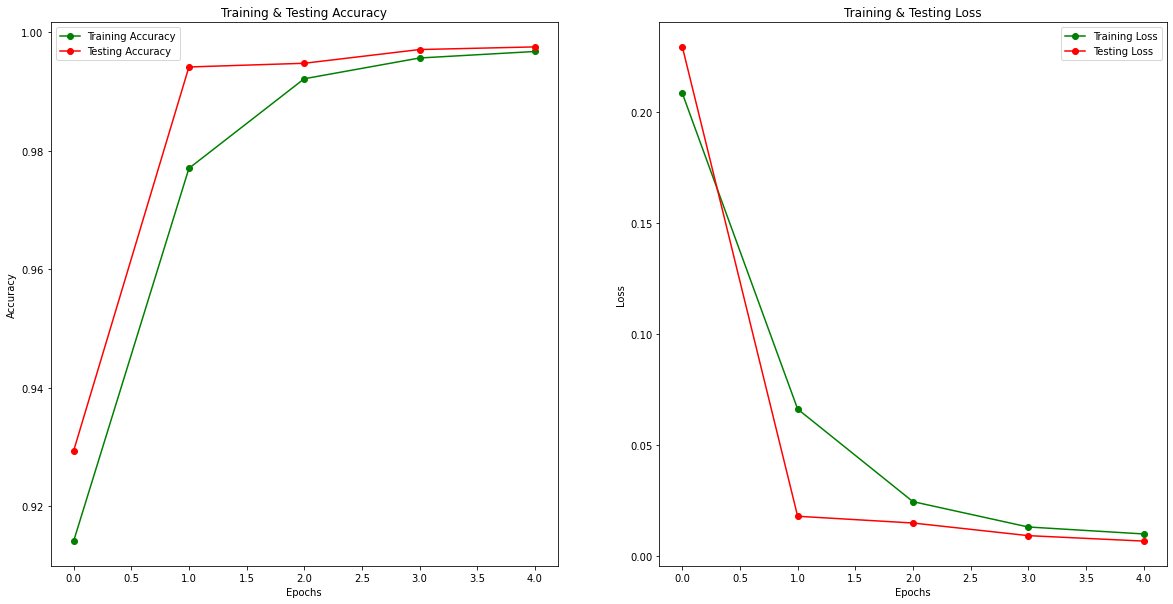

In [14]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_a = history.history['accuracy']
train_l = history.history['loss']
val_a = history.history['val_accuracy']
val_l = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_a , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_a , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_l , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_l , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [15]:
pred = model.predict_classes(X_test)
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

/home/exx/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5858
    Not Fake       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Text(69.0, 0.5, 'Actual Value')

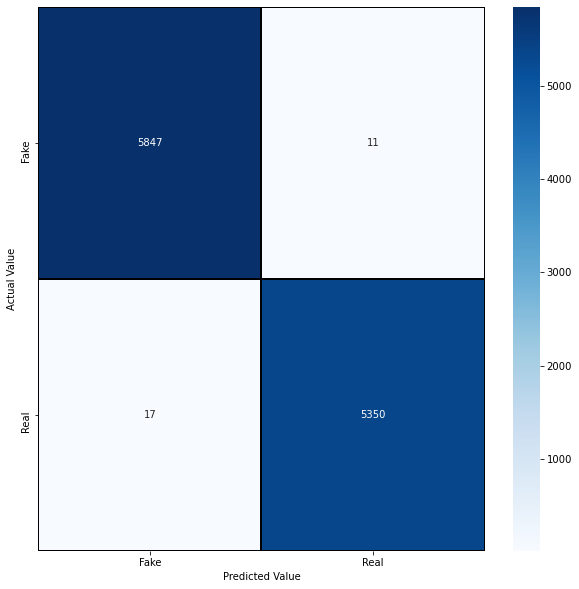

In [16]:
cm = confusion_matrix(y_test,pred)

cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")